In [1]:
import libsbml
from utils import functions
from utils import graph_functions
from utils import complete_tests
import random
import pickle
import numpy as np
import os 
from collections import defaultdict
from copy import deepcopy

In [2]:
total_species = 0
uncertain_species = 0
correct_species = 0
true_positives = 0
false_positives = 0
false_negatives = 0
true_negatives = 0 
deltas_normal = []
deltas_uncertain = []
dir = 'altered_pathways'
for experiment in list(os.listdir(dir)):
    if experiment == '.DS_Store': continue
    res_path = os.path.join(dir, experiment, 'results')
    res_file = open(res_path, 'rb')
    results = pickle.load(res_file)
    res_file.close()
    insights, all, uncertain, d_normal, d_uncertain = complete_tests.get_insights_confidence_intervals('altered', results, 1, detailed_classification=True, threshold=0, ignore_uncertain=False)
    
    total_species += all
    uncertain_species += uncertain
    
    for d in d_normal:
        deltas_normal.append(d)
    for d in d_uncertain:
        deltas_uncertain.append(d)
        
    total_count = 0
    correct_count = 0
    for specie in insights.keys():
        
        if insights[specie][0] == 0 or insights[specie][1][1] == 0.5:
            continue
        
        total_count += 1
        if insights[specie][0] == insights[specie][1][0]:
            correct_count += 1
            correct_species += 1
        
        if insights[specie][1][0] == insights[specie][0] == 1:
            true_positives += 1
        elif insights[specie][1][0] == insights[specie][0] == -1:
            true_negatives += 1
        elif insights[specie][1][0] == 1 and insights[specie][0] == -1:
            false_positives += 1
        elif insights[specie][1][0] == -1 and insights[specie][0] == 1:
            false_negatives += 1
        

out of interval, restricting confidence:  5.0 95.0 0.4866964829036637 0.5102243088601189
out of interval, restricting confidence:  7.5 92.5 0.4879418502677667 0.508916420184588
out of interval, restricting confidence:  10.0 90.0 0.48914362455578864 0.5080818520798162
out of interval, restricting confidence:  12.5 87.5 0.4901782477870089 0.5071025186482829
M uncertain set to decrease
Specie:  E expected result:  increased  normal final:  0.00014954500027157655  altered final:  0.00014995548737984537
confidence interval:  [0.8736912884093055, 0.8796199550176296]
deltas coming from simulation:  [4.1048710826881857e-07, 7.511659400131301e-06]
Specie:  E_P_1 expected result:  increased  normal final:  1.4194000643442277e-08  altered final:  1.975322584581456e-08
confidence interval:  [0.7915879427373784, 0.8067106279862886]
deltas coming from simulation:  [5.559225202372284e-09, 0.00391660205041676]
Specie:  P expected result:  increased  normal final:  0.00011971826558906014  altered final

In [3]:
print('total: ', total_species, ' correct: ', correct_species, ' uncertain: ', uncertain_species, ' true pos: ', true_positives, ' true neg: ', true_negatives, ' false_pos: ', false_positives, 'false neg: ', false_negatives,)

total:  108  correct:  60  uncertain:  4  true pos:  26  true neg:  34  false_pos:  32 false neg:  16


In [12]:
results_path = '../../../results/real_dataset/small_class/results2'
results_file = open(results_path, 'rb')
partial_results = pickle.load(results_file)
results_file.close()
partial_results

{'total_species': 290,
 'uncertain_species': 3,
 'correct_species': 235,
 'true_positives': 117,
 'false_positives': 31,
 'false_negatives': 23,
 'true_negatives': 118,
 'deltas_normal': [[-3584.0, 3.56923792846934e-29],
  [-3584.0, 3.56923792846934e-29],
  [2.876464418655189e-06, 1.05563494594709e-16],
  [2.876464418655189e-06, 1.05563494594709e-16],
  [945.7722970390278, 0.01414018094004984],
  [-945.7722970390618, 0.3095900927184679],
  [6.616437497966092, 0.1326734704369838],
  [-952.3887345370152, 0.009890061260518411],
  [0.000573871301867257, 4.919556735316632e-09],
  [0.000573871301867257, 4.919556735316632e-09],
  [-3072.0, 2.60611023348555e-29],
  [-7.759685636885004, 0.000768217154518248],
  [1.264735227170604, 2.5286051598997386e-08],
  [-1.26473522720255, 5.536217034704391e-07],
  [-1.6480795839157736e-08, 8.2317471099271765e-19],
  [-1.2647352106949938, 1.31336168294649e-05],
  [-1.6508014709304462, 1.4151625059872775e-05],
  [1024.0, 3.021577082302087e-30],
  [644.821570

In [2]:
description = {
    'species': [],
    'reactions': [],
    'connections': [],
    'altered': ''
}

In [3]:
def alter_pathway(input_filename, output_filename, alterations):
    reader = libsbml.SBMLReader()
    document = reader.readSBML(input_filename)
    model = document.getModel()

    for i in range(model.getNumParameters()):
        param = model.getParameter(i)
        if param.getId() == alterations:
            previous_value = param.getValue()
            param.setValue(previous_value * 100)
            modified_sbml = libsbml.writeSBML(document, output_filename)
            return 

In [4]:
def generate_test_set(filename):
    reader = libsbml.SBMLReader()
    document = reader.readSBML(filename)
    model = document.getModel()
    
    for i in range(model.getNumParameters()):
        base_dir = 'altered_pathways2'
        alteration_dir = os.path.join(base_dir, 'reaction_' + str(i))
        file_dir = os.path.join(alteration_dir, 'reaction_' + str(i) + '100x.xml')
        os.makedirs(alteration_dir, exist_ok=True)
        
        param = model.getParameter(i)

        alter_pathway(filename, file_dir, param.getId())

In [5]:
generate_test_set('BIOMD0000000357.xml')

In [6]:
def convert_sbml_to_network(file_path):
    
    reader = libsbml.SBMLReader()
    document = reader.readSBML(file_path)
    if document.getNumErrors() > 0:
        print("Errors occurred while loading the SBML file.")
    model = document.getModel()
    
    num_reactions = model.getNumReactions()
    num_species = model.getNumSpecies()
    
    print('number reactions', model.getNumReactions())
    print('number species', model.getNumSpecies()) 
    
    for i in range(num_species):
        description['species'].append(model.getSpecies(i).getId())
    
    for i in range(num_reactions):
        description['reactions'].append([model.getReaction(i).getId(), 0, 1])
        num_reactants = model.getReaction(i).getNumReactants()
        num_products = model.getReaction(i).getNumProducts()
        formula = model.getReaction(i).getKineticLaw().getFormula()
        formula = formula.replace('(','')
        formula = formula.replace(' ', '')
        formula_splitted = formula.split('-')
        
        if len(formula_splitted) == 2:
            description['reactions'].append([str(model.getReaction(i).getId() + 'revert'), 0, 1])
        
        for j in range(num_reactants):
            reactant = model.getReaction(i).getReactant(j).getSpecies()
            description['connections'].append([reactant, model.getReaction(i).getId()])
            if len(formula_splitted) == 2:
                description['connections'].append([str(model.getReaction(i).getId() + 'revert'), reactant])
            
        for k in range(num_products):
            product = model.getReaction(i).getProduct(k).getSpecies()
            description['connections'].append([model.getReaction(i).getId(), product])
            if len(formula_splitted) == 2:
                description['connections'].append([product, str(model.getReaction(i).getId() + 'revert')])

In [7]:
convert_sbml_to_network('BIOMD0000000357.xml')

number reactions 8
number species 9


In [8]:
for i in range(len(description['reactions'])):
    desc = deepcopy(description)
    desc['altered'] = desc['reactions'][i][0]
    base_dir = 'altered_pathways2'
    alteration_dir = os.path.join(base_dir, 'reaction_' + str(i))
    description_path = os.path.join(alteration_dir, 'description')
    description_file = open(description_path, 'wb')
    pickle.dump(desc, description_file)
    description_file.close()
    

In [2]:
total_species = 0
uncertain_species = 0
correct_species = 0
true_positives = 0
false_positives = 0
false_negatives = 0
true_negatives = 0 
deltas_normal = []
deltas_uncertain = []

complete_results = defaultdict()
for directory in list(os.listdir('altered_pathways2')):
    if directory == '.DS_Store':
        continue
    dir = os.path.join('altered_pathways2', directory)
    files = os.listdir(dir)
    description_index = 0
    altered_file_index = 0
    
    for i in range(len(files)):
        if files[i] == 'description':
            description_index = i
        elif files[i] != 'description' and files[i] != 'results':
            altered_file_index = i
            
    res = complete_tests.complete_tests2(
            'BIOMD0000000357.xml',
            os.path.join(dir, files[altered_file_index]),
            os.path.join(dir, 'description'),
            []
        )

    if res['normal']['real'] is None or res['altered']['real'] is None: continue
    
    '''complete_results_path = os.path.join(dir, 'results')
    complete_results_file = open(complete_results_path, 'wb')
    pickle.dump(res, complete_results_file)
    complete_results_file.close()'''
        
    insights, all, uncertain, d_normal, d_uncertain = complete_tests.get_insights_confidence_intervals('altered', res, 0, detailed_classification=False, threshold=0, ignore_uncertain=False)
    
    total_species += all
    uncertain_species += uncertain
    
    for d in d_normal:
        deltas_normal.append(d)
    for d in d_uncertain:
        deltas_uncertain.append(d)
        
    total_count = 0
    correct_count = 0
    for specie in insights.keys():
        
        if insights[specie][0] == 0 or insights[specie][1][1] == 0.5:
            continue
        
        total_count += 1
        if insights[specie][0] == insights[specie][1][0]:
            correct_count += 1
            correct_species += 1
        
        if insights[specie][1][0] == insights[specie][0] == 1:
            true_positives += 1
        elif insights[specie][1][0] == insights[specie][0] == -1:
            true_negatives += 1
        elif insights[specie][1][0] == 1 and insights[specie][0] == -1:
            false_positives += 1
        elif insights[specie][1][0] == -1 and insights[specie][0] == 1:
            false_negatives += 1
        
        
         
    print(directory, ' total species: ', total_count, 'correct species: ', correct_count, 'ratio: ', correct_count/total_count)
    complete_results[directory] = correct_count / total_count
    

Min and max abs differences:  1.4720231498014638e-51 3.228789058340453e-08
Min and max abs differences:  2.6492925160543744e-51 8.222857950102025e-10
reaction_10  total species:  9 correct species:  5 ratio:  0.5555555555555556
Min and max abs differences:  1.4720231498014638e-51 3.228789058340453e-08
Min and max abs differences:  1.1206518368379488e-54 5.1755459806734905e-08
reaction_5  total species:  9 correct species:  4 ratio:  0.4444444444444444
Min and max abs differences:  1.4720231498014638e-51 3.228789058340453e-08
Min and max abs differences:  5.705085363155138e-13 2.364840571478233e-06
reaction_8  total species:  9 correct species:  4 ratio:  0.4444444444444444
Min and max abs differences:  1.4720231498014638e-51 3.228789058340453e-08
Min and max abs differences:  1.2046545091486123e-69 2.16365514393857e-08
reaction_1  total species:  9 correct species:  5 ratio:  0.5555555555555556
Min and max abs differences:  1.4720231498014638e-51 3.228789058340453e-08
Converged at time

Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 810 and h = 3.63399e-09, the corrector convergence test failed repeatedly or with |h| = hmin.


reaction_0  total species:  9 correct species:  6 ratio:  0.6666666666666666


In [3]:
print('total: ', total_species, ' correct: ', correct_species, ' uncertain: ', uncertain_species, ' true pos: ', true_positives, ' true neg: ', true_negatives, ' false_pos: ', false_positives, 'false neg: ', false_negatives,)

total:  108  correct:  51  uncertain:  4  true pos:  28  true neg:  23  false_pos:  30 false neg:  27


In [13]:
partial_results['total_species'] += total_species
partial_results['uncertain_species'] += uncertain_species
partial_results['correct_species'] += correct_species
partial_results['true_positives'] += true_positives
partial_results['false_positives'] += false_positives
partial_results['true_negatives'] += true_negatives
partial_results['false_negatives'] += false_negatives
for d in deltas_normal:
    partial_results['deltas_normal'].append(d)
for d in deltas_uncertain:
    partial_results['deltas_uncertain'].append(d)

In [14]:
results_path = '../../../results/real_dataset/small_class/results2'
results_file = open(results_path, 'wb')
pickle.dump(partial_results, results_file)
results_file.close()

In [15]:
scores = []
for experiment in complete_results.keys():
    scores.append(complete_results[experiment])
print('Average score: ', np.average(np.array(scores)))

Average score:  0.48148148148148145


In [5]:
scores

[1.0,
 0.6666666666666666,
 0.8888888888888888,
 0.6666666666666666,
 0.7777777777777778,
 0.3333333333333333,
 0.4444444444444444,
 0.6666666666666666,
 0.4444444444444444,
 0.7777777777777778,
 0.4444444444444444,
 0.4444444444444444]

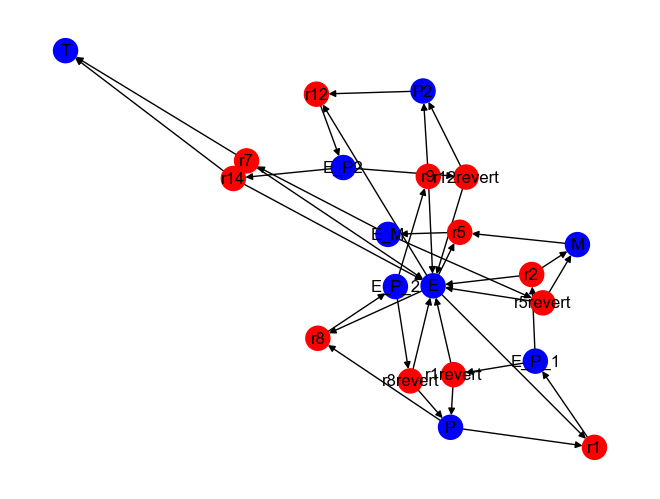

In [6]:
graph = functions.generate_graph(description)
functions.plot_graph(graph)

In [12]:
description_path = 'description_normal'
description_file = open(description_path, 'ab')
pickle.dump(description, description_file)
description_file.close()

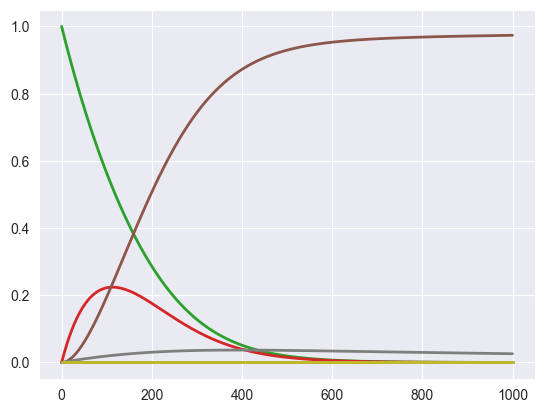

       time,         [E],     [E_P_1],         [P],         [M],       [E_M],         [T],     [E_P_2],        [P2],      [E_P2]
 [[       0,     0.00015,           0,           1,           0,           0,           0,           0,           0,           0],
  [   1.001, 7.94906e-05, 6.26737e-05,    0.994528,  0.00513008, 2.92682e-07, 3.05998e-05, 7.54092e-06, 0.000240957, 2.06306e-09],
  [   2.002, 7.95377e-05, 6.23703e-05,    0.989128,   0.0101946, 5.83368e-07, 0.000122847, 7.50442e-06, 0.000484046, 4.19768e-09],
  [   3.003, 7.95865e-05, 6.20695e-05,    0.983754,   0.0151737, 8.69508e-07, 0.000275782, 7.46822e-06, 0.000725869, 6.32385e-09],
  [   4.004, 7.96369e-05, 6.17712e-05,    0.978406,   0.0200683, 1.15118e-06, 0.000488458, 7.43232e-06, 0.000966436, 8.44175e-09],
  [ 5.00501,  7.9689e-05, 6.14753e-05,    0.973084,   0.0248798, 1.42845e-06, 0.000759942, 7.39673e-06,  0.00120576, 1.05516e-08],
  [ 6.00601, 7.97427e-05, 6.11819e-05,    0.967787,   0.0296092,  1.7014e-06,  0.0010

In [5]:
final_concentrations_normal = functions.plot_simulation_complete('BIOMD0000000357.xml')

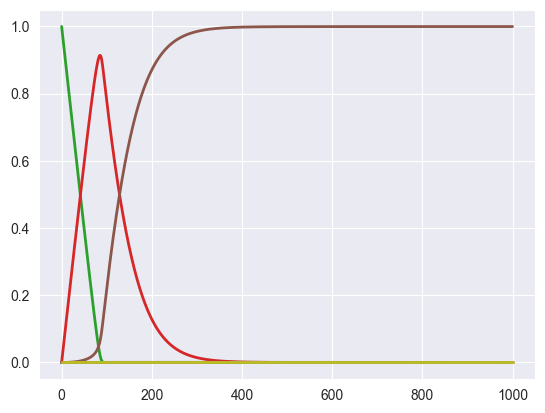

       time,         [E],      [E_P_1],          [P],         [M],       [E_M],         [T],      [E_P_2],        [P2],      [E_P2]
 [[       0,     0.00015,            0,            1,           0,           0,           0,            0,           0,           0],
  [   1.001, 1.88921e-06,  0.000147916,     0.987645,   0.0121992,   1.654e-08, 1.72251e-06,  1.77965e-07,  5.6976e-06, 1.15913e-12],
  [   2.002, 1.91233e-06,  0.000147876,     0.975441,   0.0243928,  3.3557e-08, 6.97846e-06,  1.77917e-07, 1.14508e-05,  2.3868e-12],
  [   3.003, 1.93601e-06,  0.000147835,     0.963239,   0.0365794, 5.09857e-08, 1.58529e-05,  1.77868e-07, 1.72023e-05, 3.64452e-12],
  [   4.004, 1.96029e-06,  0.000147793,     0.951042,   0.0487589, 6.88413e-08,  2.8434e-05,  1.77817e-07, 2.29522e-05,  4.9334e-12],
  [ 5.00501, 1.98517e-06,   0.00014775,     0.938847,   0.0609311, 8.71394e-08,  4.4813e-05,  1.77765e-07, 2.87004e-05,  6.2546e-12],
  [ 6.00601, 2.01068e-06,  0.000147706,     0.926657,   0.073095

In [6]:
final_concentrations_altered = functions.plot_simulation_complete('BIOMD0000000357_r1_altered.xml')

In [6]:
species = description['species']
species

['E', 'E_P_1', 'P', 'M', 'E_M', 'T', 'E_P_2', 'P2', 'E_P2']

In [8]:
final_normal = final_concentrations_normal[0][-1]
final_altered = final_concentrations_altered[0][-1]

In [9]:
final_normal

[1.00000000e+03 1.49545000e-04 1.41940006e-08 1.19718266e-04
 9.42650633e-05 1.01662649e-08 9.73788696e-01 1.70791745e-09
 2.59968660e-02 4.28931545e-07]

In [10]:
temp = final_concentrations_normal[1]
temp

[1.5e-04 0.0e+00 1.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00]

In [11]:
import math
expected_results = {}
for i in range(len(species)):
    delta1 = 0
    delta2 = 0
    print(species[i])
    if final_normal[i + 1] != 0:
        if temp[i] != 0:
            initial_concentration = temp[i]
            delta1 = math.fabs((final_altered[i + 1] - final_normal[i + 1]) / initial_concentration)
            delta2 = math.fabs(1 - (final_altered[i + 1] / final_normal[i + 1]))
            paired_delta = delta1 * delta2
        else:
            delta2 = math.fabs(1 - (final_altered[i + 1] / final_normal[i + 1]))
            paired_delta = delta2 / 100
            
        relative_delta = (final_altered[i + 1] - final_normal[i + 1]) / final_normal[i + 1]
        
    else: 
        relative_delta = 0
        
    if paired_delta >= 0.001 and final_altered[i + 1] < final_normal[i + 1]:
        expected_results[species[i]] = 'decreased'
    elif paired_delta >= 0.001 and final_altered[i + 1] > final_normal[i + 1]:
        expected_results[species[i]] = 'increased'
    else:
        expected_results[species[i]] = 'unchanged'
    
    print('final normal: ', final_normal[i + 1], 'final altered: ', final_altered[i + 1], 'delta: ', final_altered[i + 1] - final_normal[i + 1], 'relative delta ', relative_delta, 'initial concentration: ', temp[i], 'delta1', delta1, 'delta2', delta2)

E
final normal:  0.00014954500027157655 final altered:  0.00014999577616634532 delta:  4.507758947687739e-07 relative delta  0.003014316051691172 initial concentration:  0.00015 delta1 0.0030051726317918263 delta2 0.0030143160516911127
E_P_1
final normal:  1.4194000643442277e-08 final altered:  1.9003312569588688e-39 delta:  -1.4194000643442277e-08 relative delta  -1.0 initial concentration:  0.0 delta1 0 delta2 1.0
P
final normal:  0.00011971826558906014 final altered:  1.5832973931820173e-37 delta:  -0.00011971826558906014 relative delta  -1.0 initial concentration:  1.0 delta1 0.00011971826558906014 delta2 1.0
M
final normal:  9.426506332734554e-05 final altered:  1.8263426815576426e-09 delta:  -9.426323698466399e-05 relative delta  -0.9999806254553163 initial concentration:  0.0 delta1 0 delta2 0.9999806254553162
E_M
final normal:  1.0166264896386652e-08 final altered:  1.9757219365752247e-13 delta:  -1.0166067324192995e-08 relative delta  -0.9999805659014721 initial concentration:

In [12]:
expected_results

{'E': 'unchanged',
 'E_P_1': 'decreased',
 'P': 'unchanged',
 'M': 'decreased',
 'E_M': 'decreased',
 'T': 'unchanged',
 'E_P_2': 'decreased',
 'P2': 'decreased',
 'E_P2': 'decreased'}

In [4]:
description_path = 'description_normal'
description_file = open(description_path, 'rb')
description = pickle.load(description_file)
description_file.close()
description

{'species': ['E', 'E_P_1', 'P', 'M', 'E_M', 'T', 'E_P_2', 'P2', 'E_P2'],
 'reactions': [['r1', 0, 1],
  ['r1revert', 0, 1],
  ['r2', 0, 1],
  ['r5', 0, 1],
  ['r5revert', 0, 1],
  ['r7', 0, 1],
  ['r8', 0, 1],
  ['r8revert', 0, 1],
  ['r9', 0, 1],
  ['r12', 0, 1],
  ['r12revert', 0, 1],
  ['r14', 0, 1]],
 'connections': [['E', 'r1'],
  ['r1revert', 'E'],
  ['P', 'r1'],
  ['r1revert', 'P'],
  ['r1', 'E_P_1'],
  ['E_P_1', 'r1revert'],
  ['E_P_1', 'r2'],
  ['r2', 'E'],
  ['r2', 'M'],
  ['E', 'r5'],
  ['r5revert', 'E'],
  ['M', 'r5'],
  ['r5revert', 'M'],
  ['r5', 'E_M'],
  ['E_M', 'r5revert'],
  ['E_M', 'r7'],
  ['r7', 'E'],
  ['r7', 'T'],
  ['E', 'r8'],
  ['r8revert', 'E'],
  ['P', 'r8'],
  ['r8revert', 'P'],
  ['r8', 'E_P_2'],
  ['E_P_2', 'r8revert'],
  ['E_P_2', 'r9'],
  ['r9', 'E'],
  ['r9', 'P2'],
  ['E', 'r12'],
  ['r12revert', 'E'],
  ['P2', 'r12'],
  ['r12revert', 'P2'],
  ['r12', 'E_P2'],
  ['E_P2', 'r12revert'],
  ['E_P2', 'r14'],
  ['r14', 'E'],
  ['r14', 'T']],
 'altered': ''}

In [5]:
description['altered'] = 'r1'

In [23]:
description_path = 'description_r1_altered'
description_file = open(description_path, 'ab')
pickle.dump(description, description_file)
description_file.close()

In [6]:
description['reactions'][0][1] = 0.5
description

{'species': ['E', 'E_P_1', 'P', 'M', 'E_M', 'T', 'E_P_2', 'P2', 'E_P2'],
 'reactions': [['r1', 0.5, 1],
  ['r1revert', 0, 1],
  ['r2', 0, 1],
  ['r5', 0, 1],
  ['r5revert', 0, 1],
  ['r7', 0, 1],
  ['r8', 0, 1],
  ['r8revert', 0, 1],
  ['r9', 0, 1],
  ['r12', 0, 1],
  ['r12revert', 0, 1],
  ['r14', 0, 1]],
 'connections': [['E', 'r1'],
  ['r1revert', 'E'],
  ['P', 'r1'],
  ['r1revert', 'P'],
  ['r1', 'E_P_1'],
  ['E_P_1', 'r1revert'],
  ['E_P_1', 'r2'],
  ['r2', 'E'],
  ['r2', 'M'],
  ['E', 'r5'],
  ['r5revert', 'E'],
  ['M', 'r5'],
  ['r5revert', 'M'],
  ['r5', 'E_M'],
  ['E_M', 'r5revert'],
  ['E_M', 'r7'],
  ['r7', 'E'],
  ['r7', 'T'],
  ['E', 'r8'],
  ['r8revert', 'E'],
  ['P', 'r8'],
  ['r8revert', 'P'],
  ['r8', 'E_P_2'],
  ['E_P_2', 'r8revert'],
  ['E_P_2', 'r9'],
  ['r9', 'E'],
  ['r9', 'P2'],
  ['E', 'r12'],
  ['r12revert', 'E'],
  ['P2', 'r12'],
  ['r12revert', 'P2'],
  ['r12', 'E_P2'],
  ['E_P2', 'r12revert'],
  ['E_P2', 'r14'],
  ['r14', 'E'],
  ['r14', 'T']],
 'altered': '

In [7]:
for i in range(len(description['reactions'])):
    description['reactions'][i][2] = random.uniform(0, 1)

In [12]:
graph = graph_functions.generate_graph(description)

In [13]:
species_propagation = []
for i in range(100):
    print("ITERATION ", i)
    species_propagation.append(graph_functions.update_graph(graph, 1, i + 1))

ITERATION  0
---values before iteration---
{'E': 0.5, 'E_P_1': 0.5, 'P': 0.5, 'M': 0.5, 'E_M': 0.5, 'T': 0.5, 'E_P_2': 0.5, 'P2': 0.5, 'E_P2': 0.5}
Firing reaction  r1
reactant:  E  delta:  0.0
reactant:  P  delta:  0.0
{'type': 'reaction', 'strength': 0.5, 'weight': 0.5823984613535493}
new reaction strength:  0.0  reaction weight:  0.5823984613535493  reaction strength  0.5
reactant:  E  new value:  0.11920292202211755  delta:  -0.3807970779778824
reactant:  P  new value:  0.11920292202211755  delta:  -0.3807970779778824
product:  E_P_1 new value:  0.8807970779778823
Firing reaction  r1revert
reactant:  E_P_1  delta:  0.0
{'type': 'reaction', 'strength': 0, 'weight': 0.8123345441228591}
new reaction strength:  0.0  reaction weight:  0.8123345441228591  reaction strength  0
reactant:  E_P_1  new value:  0.5  delta:  0.0
product:  E new value:  0.5
product:  P new value:  0.5
Firing reaction  r2
reactant:  E_P_1  delta:  0.0
{'type': 'reaction', 'strength': 0, 'weight': 0.27378636069902

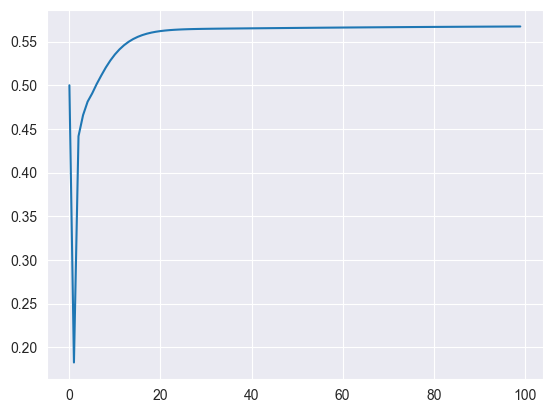

In [17]:
import matplotlib.pyplot as plt
concentrations = [conc['E_M'] for conc in species_propagation]
concentrations
plt.plot(concentrations[0:500])

In [31]:
final_propagation = species_propagation[-1]
for s in final_propagation.keys():
    print(s, 'propagation results: ', final_propagation[s], 'simulation results: ', expected_results[s])

E propagation results:  0.2909682997807277 simulation results:  unchanged
E_P_1 propagation results:  0.510966413014276 simulation results:  decreased
P propagation results:  0.6583159695128851 simulation results:  unchanged
M propagation results:  0.7570239990377047 simulation results:  decreased
E_M propagation results:  0.5116887444591705 simulation results:  decreased
T propagation results:  0.0032752408398301625 simulation results:  unchanged
E_P_2 propagation results:  0.48715279203975065 simulation results:  decreased
P2 propagation results:  0.6578018285780858 simulation results:  decreased
E_P2 propagation results:  0.4868987044646981 simulation results:  decreased


In [7]:
res = complete_tests.complete_tests2(
            'BIOMD0000000357.xml',
            'BIOMD0000000357_r1_altered.xml',
            'description_r1_altered',
            []
        )

In [9]:
insights = complete_tests.get_insights_confidence_intervals('altered', res, 1, detailed_classification=True, threshold=0.0)

Specie:  E expected result:  increased
confidence interval:  [0.3602355944125375, 0.36269963764633073]
Specie:  E_P_1 expected result:  decreased
confidence interval:  [0.5497458946442477, 0.5523985772928144]
Specie:  P expected result:  decreased
confidence interval:  [0.43717367743067437, 0.4450446757765535]
Specie:  M expected result:  decreased
confidence interval:  [0.738079354207323, 0.7449903074821347]
Specie:  E_M expected result:  decreased
confidence interval:  [0.5217557655036882, 0.5238522057724111]
Specie:  T expected result:  increased
confidence interval:  [0.21182988301783437, 0.23002592570452043]
Specie:  E_P_2 expected result:  decreased
confidence interval:  [0.45145548172106487, 0.4536383592664993]
Specie:  P2 expected result:  decreased
confidence interval:  [0.45555652258696294, 0.46779905911275127]
Specie:  E_P2 expected result:  decreased
confidence interval:  [0.4570843855768389, 0.45948979663088]


In [24]:
insights[2]

defaultdict(<function utils.complete_tests.get_insigths.<locals>.<lambda>()>,
            {'E': [0,
              0.34874761850744845,
              0.008963685965207321,
              0.3224761682382793,
              0.3782638320202059],
             'E_P_1': [-1,
              0.5009619185242649,
              0.0048854255098234114,
              0.4895746568593232,
              0.5175311157571727],
             'P': [0,
              0.5676601051842833,
              0.025581631301924358,
              0.4797791632762043,
              0.6223889847323181],
             'M': [0,
              0.6308304324154224,
              0.027632471463151558,
              0.5466429099255117,
              0.707499554898495],
             'E_M': [0,
              0.49419084545357306,
              0.0076134638966568495,
              0.47276617497309353,
              0.5148946662694255],
             'T': [0,
              0.14054968329142006,
              0.06372567000845183,
              

<Axes: ylabel='Count'>

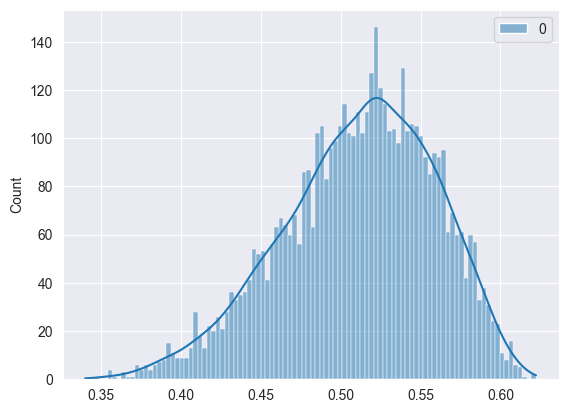

In [15]:
scores = np.array(insights[2]['P2'][-1])
df = pd.DataFrame(scores)
sns.histplot(df, kde=True, bins=100)

In [16]:
total_count = 0
correct_count = 0
for specie in insights[2].keys():
    if expected_results[specie] != 'unchanged':
        total_count += 1
    if type(specie) != type(''):
        continue
    print('specie: ', specie)
    scores = np.array(insights[2][specie][-1])
    mean = np.mean(scores)
    std = np.std(scores)
    std_error = std / np.sqrt(len(scores))
    margin = 2 * std_error
    lower = mean - margin
    higher = mean + margin
    print(' lower: ', lower, ' higher: ', higher)
    if lower > 0.5: 
        print('increase, expected: ', expected_results[specie])
        if expected_results[specie] == 'increased':
            correct_count += 1
        
    else: 
        print('decrease, expected: ', expected_results[specie])
        if expected_results[specie] == 'decreased':
            correct_count += 1
print('ratio correct: ', correct_count / total_count, 'correct: ', correct_count, 'total: ', total_count)

specie:  E
 lower:  0.34835818926417306  higher:  0.3488542961120412
decrease, expected:  unchanged
specie:  E_P_1
 lower:  0.5007947523417292  higher:  0.5010614805890593
increase, expected:  decreased
specie:  P
 lower:  0.5674803532200586  higher:  0.5688690973471319
increase, expected:  unchanged
specie:  M
 lower:  0.6294538054773636  higher:  0.6310292213312626
increase, expected:  decreased
specie:  E_M
 lower:  0.49378008069958773  higher:  0.49422168261665583
decrease, expected:  decreased
specie:  T
 lower:  0.1372454803617372  higher:  0.1406456882397343
decrease, expected:  unchanged
specie:  E_P_2
 lower:  0.4775618014522113  higher:  0.477920126476881
decrease, expected:  decreased
specie:  P2
 lower:  0.5098603654902184  higher:  0.512562867060684
increase, expected:  decreased
specie:  E_P2
 lower:  0.46480830538151846  higher:  0.46535633158757345
decrease, expected:  decreased
ratio correct:  0.5 correct:  3 total:  6
